# Medical Cost Regression - Predicting Insurance Charges

### Author: Katie McGaughey

### Date: April 20th, 2025

#### Introduction: In this project, I used the Medical Cost Dataset from Kaggle to predict insurance costs based on various factors. I explored and analyzed the dataset, developed regression models, and evaluated their performance.

## Imports

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

## Section 1. Import and Inspect the Data

### 1.1 Load the Dataset and display the first 10 rows

In [52]:
df = pd.read_csv('data/insurance.csv')
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Check for missing values and display summary statistics

In [53]:
# Check for missing values
print(df.isnull().sum())

# Display summary statistics
df.info()
display(df.describe())


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Reflection 1: What do you notice about the dataset? Are there any data issues?
- There are 1338 records and 7 features. The dataset has no missing values. There are 3 categoric features and 4 numeric features. 

## Section 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions

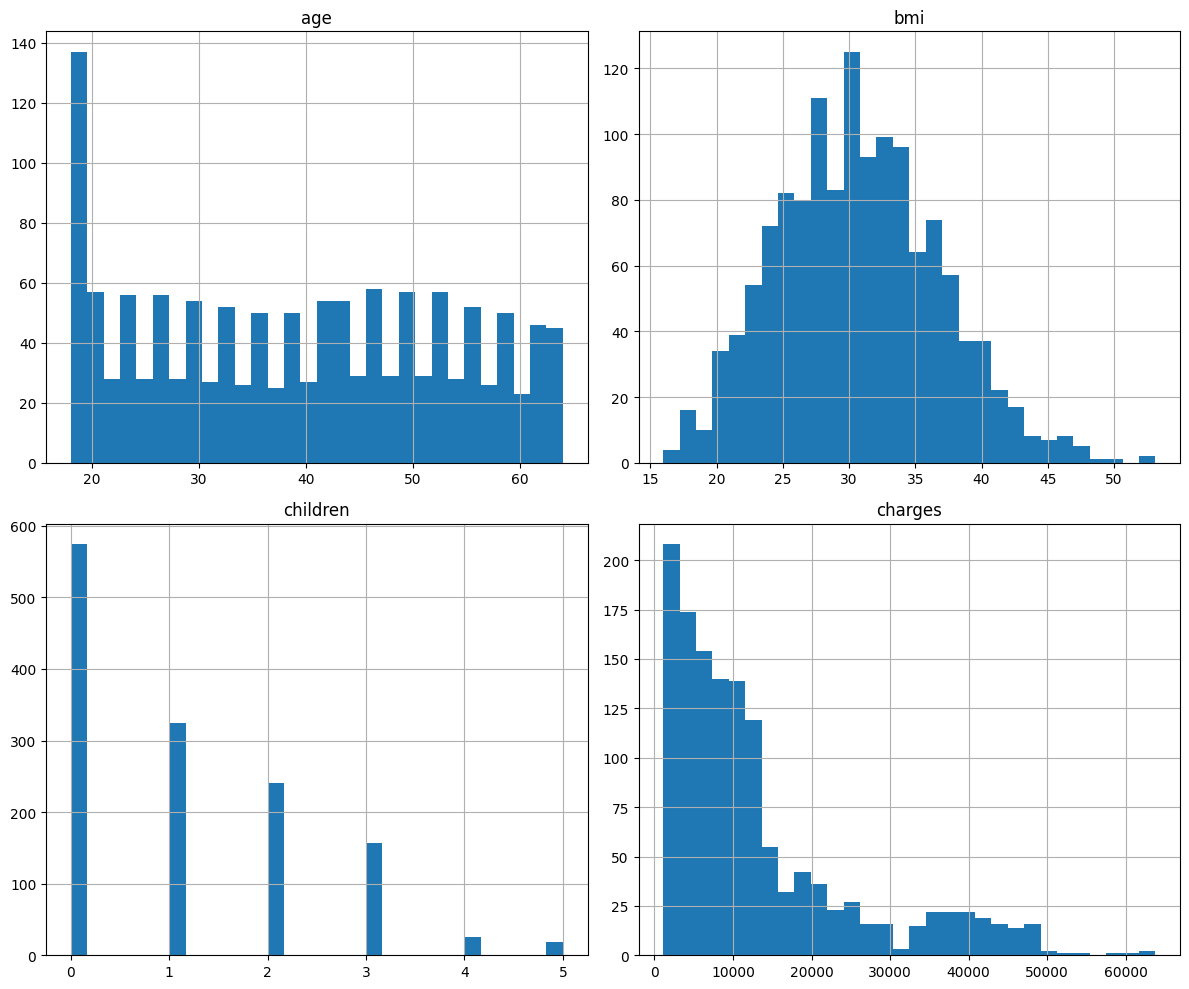

In [54]:
# Histograms for numerical features
df.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

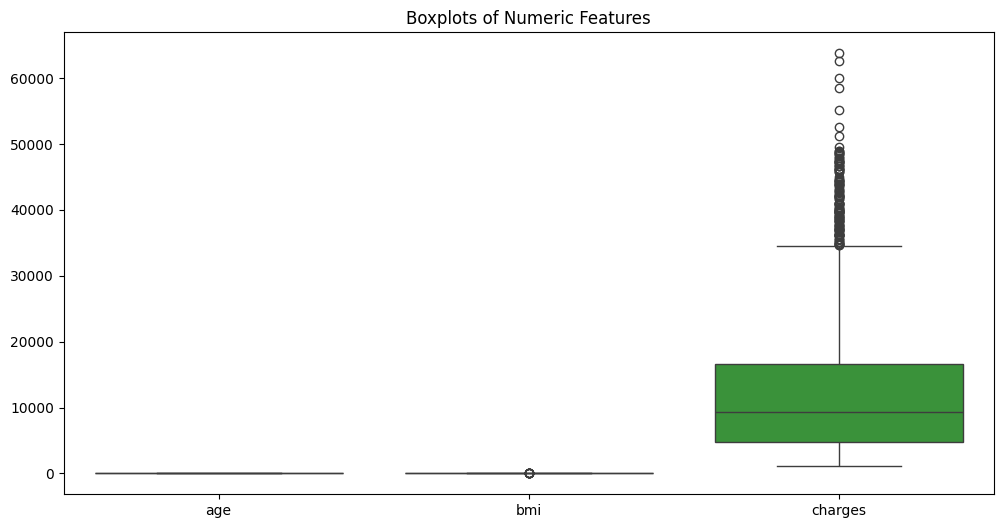

In [55]:
# Boxplots to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['age', 'bmi', 'charges']])
plt.title('Boxplots of Numeric Features')
plt.show

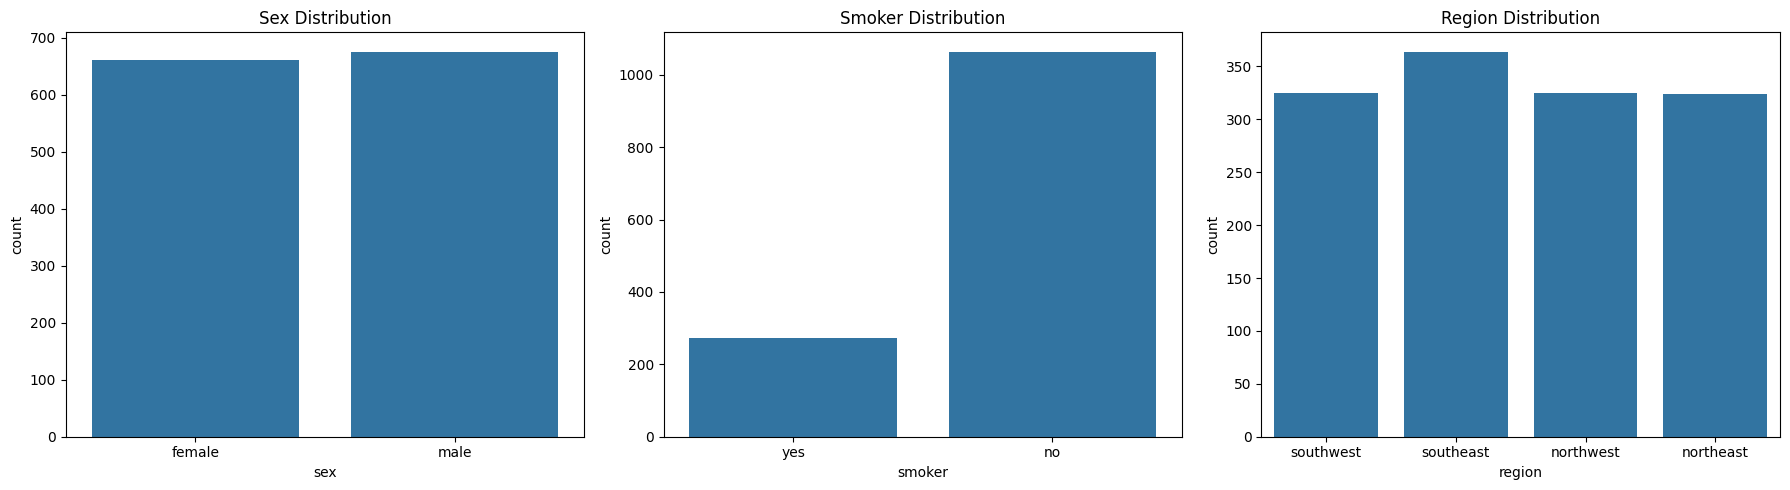

In [56]:
# Count plots for categorical variables
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(x='sex', data=df, ax=axs[0])
sns.countplot(x='smoker', data=df, ax=axs[1])
sns.countplot(x='region', data=df, ax=axs[2])
axs[0].set_title('Sex Distribution')
axs[1].set_title('Smoker Distribution')
axs[2].set_title('Region Distribution')
plt.tight_layout()
plt.show()

### 2.2 Handle Missing Values and Encode Features

In [57]:
# Convert categorical variables to numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [58]:
# Check outliers in 'charges' using IQR method
Q1 = df_encoded['charges'].quantile(0.25)
Q3 = df_encoded['charges'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_encoded[(df_encoded['charges'] < Q1 - 1.5 * IQR) | (df_encoded['charges'] > Q3 + 1.5 * IQR)]

print(f"Number of outliers in charges: {len(outliers)}")

Number of outliers in charges: 139


In [59]:
# Add 'bmi_over_30' feature (1 if obese, else 0)
df_encoded['bmi_over_30'] = (df['bmi'] > 30).astype(int)


Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?
- The dataset is clean with no missing values. Charges is highly skewed with many high outliers, likely from smoker status. A new binary feature "bmi_over_30" was created to flag obesity, which could also influence charges. 

## Section 3. Feature Selection and Justification

### 3.1 Choose features and target

In [60]:
target = 'charges'
features = ['age', 'bmi', 'smoker_yes']

### 3.2 Define X and y

In [61]:
X = df_encoded[features]
y = df_encoded[target]

Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?
- I chose these features because I believe there are strong indicators of why insurance costs can be so high. From my general knowledge, I understand those features can contribute to health risks and other factors. I believe that smoker_yes will have a strong correlation with the target of charges. 


## Section 4. Train a Model - Linear Regression

### 4.1 Split the Data

In [62]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 4.2 Train Model using Scikit-Learn model.fit

In [63]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 4.3 Evaluate Model Performance

R² Score: 0.7777
Mean Absolute Error (MAE): $4260.56
Root Mean Squared Error (RMSE): $5874.76


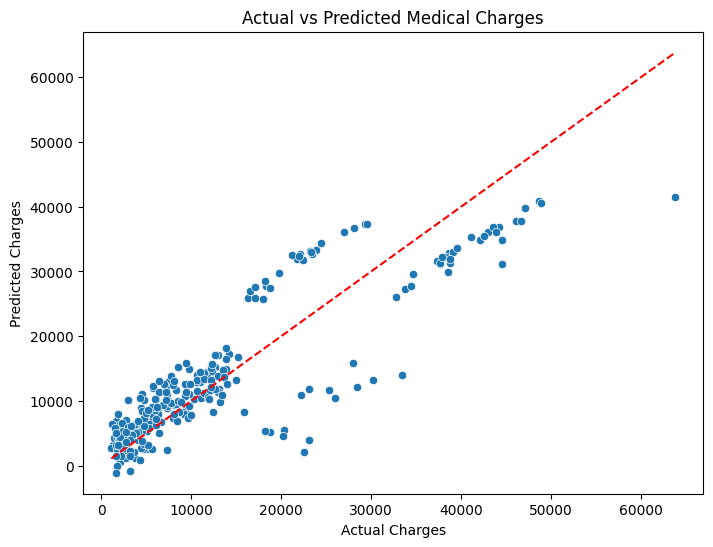

In [64]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

# Display results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Medical Charges")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()


Reflection 4: How well did the model perform? Any surprises in the results?
- The model performed well using the features of age, bmi, and smoker_yes. The R2 score of 0.7844 indicates that about 78% of the variance in the medical charges can be explained by these three predictors. As expected, I believe smoker_yes had strong influence on the prediction indicating that people who smoke tend to have higher medical costs. 

## Section 5. Improve the Model or Try Alternates (Implement Pipelines)

### 5.1 Implement Pipeline 1:  Imputer → StandardScaler → Linear Regression

In [65]:
# Pipeline 1: Standard Scaler + Linear Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluate
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)

print("Linear Regression (Scaled):")
print(f"R² Score: {r2_lr:.4f}")
print(f"Mean Absolute Error (MAE): ${mae_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_lr:.2f}")

Linear Regression (Scaled):
R² Score: 0.7777
Mean Absolute Error (MAE): $4260.56
Root Mean Squared Error (RMSE): $5874.76


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.

In [66]:
# Pipeline 2: Polynomial Features (degree=3) + Standard Scaler + Linear Regression
pipeline_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline_poly.fit(X_train, y_train)
y_pred_poly = pipeline_poly.predict(X_test)

# Evaluate
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = root_mean_squared_error(y_test, y_pred_poly)

print("Polynomial Regression (Degree 3, Scaled):")
print(f"R² Score: {r2_poly:.4f}")
print(f"Mean Absolute Error (MAE): ${mae_poly:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_poly:.2f}")



Polynomial Regression (Degree 3, Scaled):
R² Score: 0.8615
Mean Absolute Error (MAE): $2838.44
Root Mean Squared Error (RMSE): $4637.02


### 5.3 Compare Performance

In [67]:
results = pd.DataFrame({
    "Model": ["Linear Regression (Scaled)", "Polynomial Regression (Degree 3, Scaled)"],
    "R²": [r2_lr, r2_poly],
    "MAE": [mae_lr, mae_poly],
    "RMSE": [rmse_lr, rmse_poly]
})

results

,Model,R²,MAE,RMSE
0,Linear Regression (Scaled),0.777693,4260.560091,5874.763304
1,"Polynomial Regression (Degree 3, Scaled)",0.861500,2838.443408,4637.021659


Reflection 5: Which model performed better? Why might one classifier be more effective in this specific case?
- Both pipelines performed well and had strong results. Linear Regression was more simple and faster to train while the Polynomial Regression model had a higher R2 score, which indicates that it capture more variance that might have resulted from overfitting. There was not a need for an imputer since there are no missing values in this dataset. Standard scaling helped normalized the features to prevent bmi and age from dominating the model due to their numeric ranges. The basic linear regression model from Section 4 performed well and is easier to understand. 

## Section 6. Final Thoughts & Insights

6.1 Summarize findings.
- The Linear Regression model built in Section 4 used features of "age", "bmi" and "smoker_yes" and performed well, achieving a R2 score of 0.7844. In Section 5, pipelines were implemented and the Linear Regression model that was scaled using StandardScaler performed the same as the base linear regression model in Section 4. The polynomial regression model with Standard Scaler performed slightly better but overfitting possibly occurred. 

6.2 Discuss challenges faced.
- I did not face major challenges when building these regression models. 

6.3 If you had more time, what would you try next?
- I would explore additional features to predict the target variable and compare their performance against the features currently used. Additionally, I'd like to evaluate other models to assess and compare their effectiveness. 

Reflection 6: What did you learn from this project? 
- I gained experience interpreting results from multiple regression models and improved my ability to structure a notebook from scratch. By using real-world data, I practiced developing a consistent workflow that can be applied to future projects and professional settings.